### asking for the weights in the prompt

In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from functions import text_extraction

load_dotenv()
llm = ChatOpenAI(
    model = "gpt-4o-mini-2024-07-18"
)

job_description = text_extraction(
    "/Users/santiagocardenas/Documents/MDSI/202502/internship/internship_project/data/raw/job/data_role_des.txt"
)

company_info = (
    "At Synogize, we craft powerful, scalable Data and AI solutions that fuel your growth."
    "Our technology empowers you with trusted insights so you can make bold, data-driven decisions that drive your success."
)

In [ ]:
from pydantic import BaseModel, Field, field_validator
from typing import List, Any, Optional, Literal, Dict, Annotated

class EvaluationCriteria(BaseModel):
    """criteria to evaluate candidates"""
    domains : List[str] = Field(
        description = "List of key subject areas or industries relevant to the role"
    )
    technical_skills : List[str] = Field(
        description = "List of specific technologies, programming languages, and tools required."
    )
    soft_skills : List[str] = Field(
        description = "List of interpersonal abilities and qualities necessary for success at work"
    )
    culture : List[str] = Field(
        description = "List of traits that align with the company's culture and values"
    )
    @field_validator("*")
    @classmethod
    def check_criteria(cls, v: List[str]):
        if len(v) == 0:
            raise ValueError("The list should contain at least one value")
        return v

# improvement for the weights
class CriteriaWeights(BaseModel):
    """class for the weights of components derived from the evaluation criteria"""
    domains: int = Field(..., ge=0, le=100)
    technical_skills: int = Field(..., ge=0, le=100)
    soft_skills: int = Field(..., ge=0, le=100)
    culture: int = Field(..., ge=0, le=100)
    
# new schema that incorporates the weights
class WeightedEvaluationCriteria(BaseModel):
    criteria: EvaluationCriteria
    weights: CriteriaWeights
    
    @field_validator('weights')
    @classmethod
    def check_sum_of_weights(cls, v: CriteriaWeights):
        total_weight = v.domains + v.technical_skills + v.soft_skills + v.culture
        if total_weight != 100:
            raise ValueError(f"Sum of weights must be 100, but got {total_weight}")
        return v

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
criteria_template = [
    (
        "system",
        (
            "You are an expert recruiter. Your task is to analyze a job description and extract the key skills and areas"
            "a candidate should be evaluated on. For each category, provide a concise list of strings."
            "Limit each list to a maximum of 5 elements and avoid making tool specific criteria."
        ),
    ),
    (
        "human",
        (
            "Please provide a JSON object with the following keys. Each key's value should be a concise list of strings "
            "relevant to the job description provided.\n\n"
            "- **domains**: Key subject areas or industries relevant to the role.\n"
            "- **technical_skills**: Specific technologies, programming languages, and tools required.\n"
            "- **soft_skills**: Interpersonal abilities and qualities necessary for success at work.\n"
            "- **culture**: Traits that align with the company's culture and values.\n\n"
            "**Job Description:**\n{job_description}\n\n"
            "**Company Details:**\n{company_info}\n\n"
        ),
    ),
]
criteria_prompt = ChatPromptTemplate.from_messages(messages = criteria_template)

#### current implementation

In [4]:
generation_messages = criteria_prompt.invoke({
    "job_description" : job_description,
    "company_info" : company_info
}).messages
generation_messages

[SystemMessage(content='You are an expert recruiter. Your task is to analyze a job description and extract the key skills and areasa candidate should be evaluated on. For each category, provide a concise list of strings. Limit each list to a maximum of 5 elements and avoid making tool specific criteria.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Please provide a JSON object with the following keys. Each key's value should be a concise list of strings relevant to the job description provided.\n\n- **domains**: Key subject areas or industries relevant to the role.\n- **technical_skills**: Specific technologies, programming languages, and tools required.\n- **soft_skills**: Interpersonal abilities and qualities necessary for success at work.\n- **culture**: Traits that align with the company's culture and values.\n\n**Job Description:**\nGraduate Consultant - Data & Analytics\nAre you a recent graduate with a passion for data and a desire to build a career in an

In [5]:
llm_constrained = llm.with_structured_output(schema = EvaluationCriteria)
msg = llm_constrained.invoke(
    input = generation_messages
)
msg

EvaluationCriteria(domains=['Data Analytics', 'Business Transformation', 'Consulting', 'Information Technology', 'Data Science'], technical_skills=['SQL', 'ETL/ELT Processes', 'Data Transformation Tools', 'Data Visualization Tools', 'Cloud Platforms'], soft_skills=['Problem-Solving', 'Communication', 'Collaboration', 'Curiosity', 'Teamwork'], culture=['Growth-Oriented', 'Client-Centric', 'Innovative', 'Team Collaboration', 'Proactive Learning'])

#### modification for the weights

In [16]:
criteria_template_v2 = [
    (
        "system",
        "You are an expert recruiter. Your task is to analyze a job description and extract the key skills and areas"
        "a candidate should be evaluated on. For each category, provide a concise list of strings and a list"
        "of the weights for each category"
        "Limit each list to a maximum of 5 elements and avoid making tool specific criteria."
        "The list of weights must add exactly 100 and the order must be the same as the specified categories"
    ),
    (
        "human",
        "Please provide a JSON object with the following keys."
        "The first 4 values of the keys should be a concise list of 5 strings"
        "The 'weights' key should be a list of weights of the previous 4 keys"
        "relevant to the job description provided.\n\n"
        "- **domains**: Key subject areas or industries relevant to the role.\n"
        "- **technical_skills**: Specific technologies, programming languages, and tools required.\n"
        "- **soft_skills**: Interpersonal abilities and qualities necessary for success at work.\n"
        "- **culture**: Traits that align with the company's culture and values.\n"
        "- **weights**: [<integer_percentage_domains>, <integer_percentage_technical_skills>, <integer_percentage_soft_skills>, <integer_percentage_culture>]\n\n"
        "**Job Description:**\n{job_description}\n\n"
        "**Company Details:**\n{company_info}\n\n"
    )
]
criteria_prompt_v2 = ChatPromptTemplate.from_messages(messages = criteria_template_v2)

generation_messages_v2 =  criteria_prompt_v2.invoke({
    "job_description" : job_description,
    "company_info" : company_info
}).messages
generation_messages_v2

[SystemMessage(content='You are an expert recruiter. Your task is to analyze a job description and extract the key skills and areasa candidate should be evaluated on. For each category, provide a concise list of strings and a listof the weights for each categoryLimit each list to a maximum of 5 elements and avoid making tool specific criteria.The list of weights must add exactly 100 and the order must be the same as the specified categories', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="Please provide a JSON object with the following keys.The first 4 values of the keys should be a concise list of 5 stringsThe 'weights' key should be a list of weights of the previous 4 keysrelevant to the job description provided.\n\n- **domains**: Key subject areas or industries relevant to the role.\n- **technical_skills**: Specific technologies, programming languages, and tools required.\n- **soft_skills**: Interpersonal abilities and qualities necessary for success at work.\n-

In [17]:
import numpy as np
class EvaluationCriteriaV2(BaseModel):
    """criteria to evaluate candidates"""
    domains : List[str] = Field(
        description = "List of key subject areas or industries relevant to the role"
    )
    technical_skills : List[str] = Field(
        description = "List of specific technologies, programming languages, and tools required."
    )
    soft_skills : List[str] = Field(
        description = "List of interpersonal abilities and qualities necessary for success at work"
    )
    culture : List[str] = Field(
        description = "List of traits that align with the company's culture and values"
    )
    weights : List[int] = Field(
        description = "List of weights for each component"
    )
    @field_validator("domains", "technical_skills", "soft_skills", "culture")
    @classmethod
    def check_criteria(cls, v: List[str]):
        if len(v) == 0:
            raise ValueError("The list should contain at least one value")
        return v
    @field_validator("weights")
    @classmethod
    def check_weigths(cls, v : List[int]):
        if np.sum(v) != 100:
            raise ValueError("The weights must add to exactly 100")
        return v

In [18]:
llm_constrained = llm.with_structured_output(schema = EvaluationCriteriaV2)
msg = llm_constrained.invoke(
    input = generation_messages_v2
)
msg

EvaluationCriteriaV2(domains=['Data Analytics', 'Business Transformation', 'Client Engagement', 'Data Governance', 'Data Modeling'], technical_skills=['SQL', 'ETL Processes', 'Data Transformation Tools', 'Data Visualization Tools', 'Cloud Platforms'], soft_skills=['Problem-Solving', 'Team Collaboration', 'Communication Skills', 'Eagerness to Learn', 'Client-Focused Mindset'], culture=['Innovation', 'Collaboration', 'Continuous Improvement', 'Supportive Environment', 'Growth-Oriented'], weights=[25, 35, 25, 15])

### Memory of the generator-evaluator

#### basic usage of messages

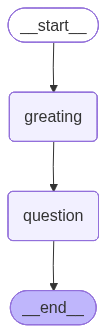

In [20]:
from typing import Annotated
from IPython.display import Image, display
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

class MessagesState(BaseModel):
    """information that flows in the graph"""
    messages: Annotated[list[AnyMessage], add_messages]

# simple nodes
def greating_node(state : MessagesState) -> MessagesState:
    """adds a greating message"""
    state.messages = [AIMessage(content = "I am a helpful assistant, how can I help you?")]
    return state

def question_node(state : MessagesState) -> MessagesState:
    """adds a question"""
    state.messages = [HumanMessage(content = "How many moons does saturn have?")]
    return state

mini_graph = StateGraph(MessagesState)
mini_graph.add_node("greating", greating_node)
mini_graph.add_node("question", question_node)
mini_graph.set_entry_point("greating")
mini_graph.add_edge("greating", "question")
mini_graph.add_edge("question", END)
mini_graph_compiled = mini_graph.compile()

display(Image(mini_graph_compiled.get_graph().draw_mermaid_png()))

In [21]:
sample_input = MessagesState(
    messages = [HumanMessage(content = "Hi!")]
)
results = mini_graph_compiled.invoke(
    input = sample_input
)
results

{'messages': [HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='ca00894d-3233-4ff1-af92-782cad4941f5'),
  AIMessage(content='I am a helpful assistant, how can I help you?', additional_kwargs={}, response_metadata={}, id='79242b32-3bb4-4ddd-96ec-44fe87943328'),
  HumanMessage(content='How many moons does saturn have?', additional_kwargs={}, response_metadata={}, id='81804ee3-e89b-43ef-abe0-6eddd81ed9db')]}

In [22]:
for m in results['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

I am a helpful assistant, how can I help you?
================================ Human Message =================================

How many moons does saturn have?


#### generator-evaluator with memory

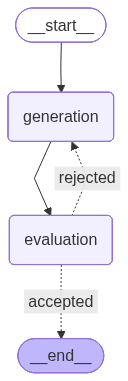

In [ ]:
from typing import Optional, Literal, List, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AnyMessage, BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from functions import print_execution_status
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, display

load_dotenv()
llm = ChatOpenAI(
    model = "gpt-4o-mini-2024-07-18"
)

# backbone
class CriteriaSimple(BaseModel):
    """simple evaluatuation criteria"""
    tech_skills : List[str] = Field(
        description = "List of technical skills"
    )
    soft_skills : List[str] = Field(
        description = "list o interpersonal abilities or qualities"
    )

class FeedbackSimple(BaseModel):
    """simple feedback response"""
    grade : Literal['good', 'needs improvement'] = Field(
        description = "decide if the criteria is good or needs improvement"
    )
    feedback : str = Field(
        description = "If the criteria is not good enough, provide feedback on how to improve it"
    )

class GenEvalState(BaseModel):
    """information that will flow through the workflow"""
    messages : Optional[Annotated[List[AnyMessage], add_messages]] = None # conversation history between agents and human
    feedback : Optional[str] = None # feedback provided from the agent or human
    status : Optional[Literal['good', 'needs improvement']] = None # status of the criteria
    job_description : str
    criteria : Optional[CriteriaSimple] = None

# generation template
generation_template = [
    (
        "system",
        "Analyse the job description and extract critial technical skills and soft skills that a candidate"
        "should be evaluated on. For each category, provide a list of strings"
        "Each list must contain only 3 elements"
    ),
    (
        "human",
        "Please provide a JSON object with the following keys. Each key's values should be a concise list of 3 strings"
        "relevant to the job description provided.\n\n"
        "- **technical_skills**: specific technologies and tools required for the job\n"
        "- **soft_skills**: interpersonal abilities and qualities for success at work\n\n"
        "**Job Description:**\n{job_description}"
    )
]
generation_prompt = ChatPromptTemplate.from_messages(messages = generation_template)
# feedback template
feedback_template = [
    (
        "system",
        "Your task is to analyse a job description and the evaluation criteria for job description."
        "You need to assess whether the evaluation criteria aligns with the job description, ensuring"
        "that the critieria is tool specific"
    ),
    (
        "human",
        "Please evaluate how aligned and relevant is the following evaluation criteria for the provided job description.\n"
        "Make sure that the criteria is concise and is not tool specific.\n\n"
        "- **technical_skills**: {tech_skills_string}\n"
        "- **soft_skills**: {soft_skills_string}\n\n"
        "**Job Description:**\n{job_description}\n\n"
        "If the criteria provided is not satisfactory, provide some feedback on how to improve it"
        # to what extent this is not satisfactory? how to define satisfactory? 
    )
]
feedback_prompt = ChatPromptTemplate.from_messages(messages = feedback_template)
# generation template with feedback
generation_with_feedback_template = [
    (
        "system",
        "Analyse the job description and extract critial technical skills and soft skills that a candidate"
        "should be evaluated on. For each category, provide a list of strings"
        "Each list must contain only 3 elements"
    ),
    (
        "human",
        "Please provide a JSON object with the following keys. Each key's values should be a concise list of 3 strings"
        "relevant to the job description provided.\n\n"
        "- **technical_skills**: specific technologies and tools required for the job\n"
        "- **soft_skills**: interpersonal abilities and qualities for success at work\n\n"
        "**Job Description:**\n{job_description}\n\n"
        "Consider the following feedback when generating the criteria\n"
        "**Feedback:**\n{feedback}"
    )
]
generation_with_feedback_prompt = ChatPromptTemplate.from_messages(messages = generation_with_feedback_template)

# nodes
@print_execution_status
def criteria_generation(state: GenEvalState) -> GenEvalState:
    """Generates the criteria to evaluate the candidates."""
    llm_constrained = llm.with_structured_output(schema=CriteriaSimple)
    if not state.feedback:  # initial case, when there is no feedback
        initial_messages = generation_prompt.invoke({
            "job_description": state.job_description
        }).messages
        state.messages = initial_messages  # initialize messages
    else:
        followup_messages = generation_with_feedback_prompt.invoke({
            "job_description": state.job_description,
            "feedback": state.feedback
        }).messages
        state.messages += followup_messages  # append follow-up messages

    msg = llm_constrained.invoke(input = state.messages)
    state.criteria = msg
    state.messages += [AIMessage(content=(
        f"technical skills: {','.join(state.criteria.tech_skills)}\n"
        f"soft skills: {','.join(state.criteria.soft_skills)}"
    ))]
    return state

@print_execution_status
def criteria_evaluation(state: GenEvalState) -> GenEvalState:
    """Evaluates the criteria and provides feedback on the criteria."""
    llm_constrained = llm.with_structured_output(schema=FeedbackSimple)
    evaluation_messages = feedback_prompt.invoke({
        "tech_skills_string": ', '.join(state.criteria.tech_skills),
        "soft_skills_string": ', '.join(state.criteria.soft_skills),
        "job_description": state.job_description
    }).messages
    state.messages += evaluation_messages  # append evaluation messages

    msg = llm_constrained.invoke(input=state.messages)
    state.feedback = msg.feedback
    state.status = msg.grade
    state.messages += [AIMessage(content=(
        f"The feedback from the criteria is: {state.feedback}"
    ))]
    return state

# routing node
@print_execution_status
def route_evaluation(state : GenEvalState) -> Literal["accepted", "rejected"]:
    """routes the evaluation based on the status attribute of the state"""
    # maybe its worth limiting the messages at this point
    if state.status == "good":
        return "accepted"
    else:
        return "rejected"

### making the graph
workflow = StateGraph(GenEvalState)
# making the nodes
workflow.add_node("generation", criteria_generation)
workflow.add_node("evaluation", criteria_evaluation)
# connecting the nodes
workflow.add_edge(START, "generation")
workflow.add_edge("generation", "evaluation")
workflow.add_conditional_edges(
    source = "evaluation",
    path = route_evaluation,
    path_map = {
        "accepted" : END,
        "rejected" : "generation"
    }
)
# compile the workflow
compiled_workflow = workflow.compile()

display(Image(compiled_workflow.get_graph().draw_mermaid_png()))


In [30]:
from functions import text_extraction
job_description = text_extraction(
    "/Users/santiagocardenas/Documents/MDSI/202502/internship/internship_project/data/raw/job/data_role_des.txt"
)
sample_input = GenEvalState(
    job_description = job_description
)

sample_results = compiled_workflow.invoke(
    input = sample_input
)

executing function: 'criteria_generation'
'criteria_generation' was successfully executed!
------------------------------
executing function: 'criteria_evaluation'
'criteria_evaluation' was successfully executed!
------------------------------
executing function: 'route_evaluation'
'route_evaluation' was successfully executed!
------------------------------
executing function: 'criteria_generation'
'criteria_generation' was successfully executed!
------------------------------
executing function: 'criteria_evaluation'
'criteria_evaluation' was successfully executed!
------------------------------
executing function: 'route_evaluation'
'route_evaluation' was successfully executed!
------------------------------


In [31]:
for m in sample_results['messages']:
    m.pretty_print()

================================ System Message ================================

Analyse the job description and extract critial technical skills and soft skills that a candidateshould be evaluated on. For each category, provide a list of stringsEach list must contain only 3 elements
================================ Human Message =================================

Please provide a JSON object with the following keys. Each key's values should be a concise list of 3 stringsrelevant to the job description provided.

- **technical_skills**: specific technologies and tools required for the job
- **soft_skills**: interpersonal abilities and qualities for success at work

**Job Description:**
Graduate Consultant - Data & Analytics
Are you a recent graduate with a passion for data and a desire to build a career in analytics and business transformation? Do you enjoy solving complex problems and delivering innovative, data-driven solutions that empower businesses? If so, Synogize is excited to 

In [26]:
sample_results

{'messages': [SystemMessage(content='Your task is to analyse a job description and the evaluation criteria for job description.You need to assess whether the evaluation criteria aligns with the job description, ensuringthat the critieria is tool specific', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Please evaluate how aligned and relevant is the following evaluation criteria for the provided job description.\nMake sure that the criteria is concise and is not tool specific- **technical_skills**: Proficiency in SQL, Experience with dbt or Matillion for data transformation, Basic skills in creating visualizations using Tableau or Power BIb\n- **soft_skills**: Strong communication skills for client engagement, Eagerness to learn and tackle new challenges, Collaborative mindset to work in a team-oriented environment\n\n**Job Description:**\nGraduate Consultant - Data & Analytics\nAre you a recent graduate with a passion for data and a desire to build a career in an